In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Dataset 1: Sales

This tells us about the number of units sold for a particular item at a particular store on a given date

In [5]:
sales_df = pd.read_csv("datasets/train.csv")

/var/folders/7c/t5z2cmhs79z_0qxbr2j8k3ww0000gn/T/ipykernel_90770/3786806160.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("datasets/train.csv")


In [6]:
# checking the sales data
sales_df.head(20)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [7]:
sales_df['unit_sales'].describe()

count    1.254970e+08
mean     8.554865e+00
std      2.360515e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

The negative values denote the returns of the products

In [8]:
# In this sections, the date column of the sales data is analysed to check if there are any missing dates.


min_date = sales_df["date"].min()
max_date = sales_df["date"].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

# Generate a complete date range from min_date to max_date
full_date_range = pd.date_range(start=min_date, end=max_date)

# Find missing dates by comparing the full date range to the dates in the dataframe
missing_dates = full_date_range.difference(sales_df["date"])

if not missing_dates.empty:
    print("Missing dates:", missing_dates)
else:
    print("No dates are missing.")

Minimum date: 2013-01-01
Maximum date: 2017-08-15
Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


From the output, we can understand that the stores are closed on 25th Decemeber every year.There is no need to fill this data because the stores are expected to be closed on this date in future as well.

In [9]:
# 1. Now, we need to understand that if a product is not sold on a particular day in a store, does the file contain a row with 0 in the 
#    unit_sales column to show this or the row is completely omitted.
# 2. Checking if value 0 exists in the column unit sales


zero_values_count = (sales_df["unit_sales"] == 0).sum()
print("Number of values equal to 0 in unit_sales:", zero_values_count)

Number of values equal to 0 in unit_sales: 0


It is found that if a product is not sold on a particular day, then a row to show this information does not exist

In [10]:
# checking for missing values
null_counts = sales_df[["date","store_nbr", "item_nbr", "unit_sales", "onpromotion"]].isnull().sum()

print("Null values in each column:")
print(null_counts)

Null values in each column:
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64


The onpromotion column have lots of missing values. Lets analyse the column first to address it.

In [11]:
# Priting the unique values of onpromotion column.
unique_onpromotion_values = sales_df["onpromotion"].unique()

print("Unique values in 'onpromotion' column:")
print(unique_onpromotion_values)

unique_onpromotion_value_counts = sales_df["onpromotion"].value_counts()
print("The count for each value : ", unique_onpromotion_value_counts)

Unique values in 'onpromotion' column:
[nan False True]
The count for each value :  onpromotion
False    96028767
True      7810622
Name: count, dtype: int64


In [12]:
# The missing values are addressed by replacing the nan values with False.
# The boolean True and False values are replaced with 0s and 1s.
sales_df['onpromotion'].fillna(0, inplace=True)
sales_df['onpromotion'] = sales_df['onpromotion'].astype(int)
sales_df['onpromotion'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: onpromotion, dtype: int64

We can see that the column is tranformed from boolean to int (0s and 1s)

In [13]:
# Checking if the data type of each column is as expected.
print(sales_df.dtypes)

id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion      int64
dtype: object


In [14]:
# We need to check if the date column can be converted to date type.
sales_df["date"] = pd.to_datetime(sales_df["date"]).dt.date

In [15]:
print(sales_df.dtypes)

id               int64
date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion      int64
dtype: object


Even if the dtype is shown as object, this means the column contains native Python date objects (not datetime64), which is expected when using .dt.date.
It is not converted to datetime for simplicity.

Now we we need to analyse the unit_sales column to check for outliers.

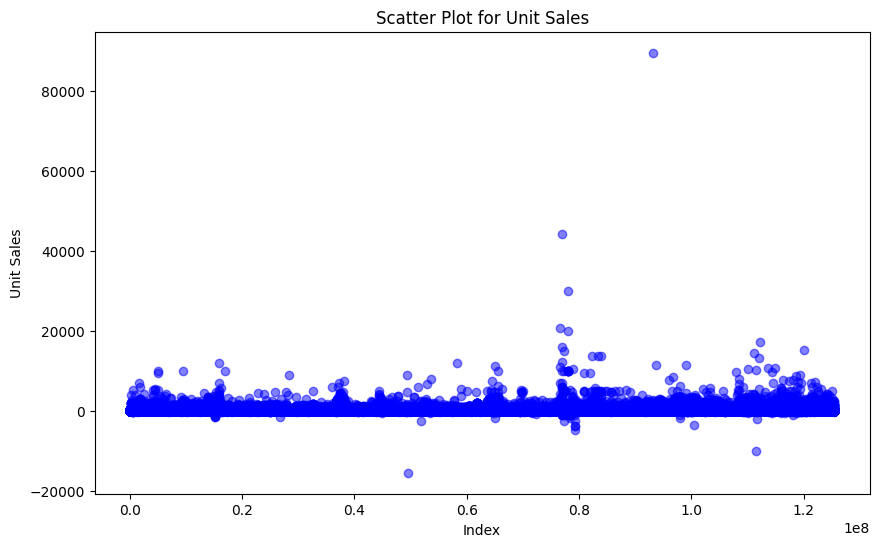

In [16]:
# Scatter plot is plotted to visually identify outliers.

plt.figure(figsize=(10, 6))
plt.scatter(sales_df.index, sales_df["unit_sales"], alpha=0.5, color='blue')
plt.title("Scatter Plot for Unit Sales")
plt.xlabel("Index")
plt.ylabel("Unit Sales")
plt.show()


We can see that there are two outliers with positive unit_sales value and two values with negative sales values. Lets just check some of the outlier rows.

In [17]:
# Print the rows with the maximum and minimum unit_sales
max_row = sales_df.loc[sales_df["unit_sales"].idxmax()]
min_row = sales_df.loc[sales_df["unit_sales"].idxmin()]

print("Row with maximum unit_sales:")
print(max_row)

print("\nRow with minimum unit_sales:")
print(min_row)

Row with maximum unit_sales:
id               93189596
date           2016-10-07
store_nbr              39
item_nbr          1976284
unit_sales        89440.0
onpromotion             0
Name: 93189596, dtype: object

Row with minimum unit_sales:
id               49592112
date           2015-06-22
store_nbr              18
item_nbr          1166474
unit_sales       -15372.0
onpromotion             0
Name: 49592112, dtype: object


For the two postive outliers, replace the unit_sales with the value of sales on the previous for the store and item number combination.

In [18]:
sales_df_sorted = sales_df[sales_df["unit_sales"] > 0].sort_values(by="unit_sales", ascending=False)

# Get the two rows with the highest positive unit_sales
top_two_rows = sales_df_sorted.head(2)

# Get the previous row for each of these top two rows (same store_nbr and item_nbr)
previous_row_1 = sales_df[(sales_df["store_nbr"] == top_two_rows.iloc[0]["store_nbr"]) & (sales_df["item_nbr"] == top_two_rows.iloc[0]["item_nbr"]) & (sales_df.index < top_two_rows.index[0])].iloc[-1]
previous_row_2 = sales_df[(sales_df["store_nbr"] == top_two_rows.iloc[1]["store_nbr"]) & (sales_df["item_nbr"] == top_two_rows.iloc[1]["item_nbr"]) & (sales_df.index < top_two_rows.index[1])].iloc[-1]

# Fill the unit_sales and onpromotion columns with values from the previous rows
sales_df.loc[top_two_rows.index[0], ["unit_sales", "onpromotion"]] = previous_row_1[["unit_sales", "onpromotion"]]
sales_df.loc[top_two_rows.index[1], ["unit_sales", "onpromotion"]] = previous_row_2[["unit_sales", "onpromotion"]]

print("Updated rows with the highest positive unit_sales after filling with previous values:")
print(sales_df.loc[top_two_rows.index])


Updated rows with the highest positive unit_sales after filling with previous values:
                id        date  store_nbr  item_nbr  unit_sales  onpromotion
93189596  93189596  2016-10-07         39   1976284      2230.0            0
76939364  76939364  2016-04-21         20    841842       169.0            0


Use the same technique to correct the two negative outliers as well.

In [19]:

sales_df_sorted = sales_df[sales_df["unit_sales"] < 0].sort_values(by="unit_sales", ascending=True)

# Get the two rows with the lowest negative unit_sales
bottom_two_rows = sales_df_sorted.head(2)

previous_row_1 = sales_df[(sales_df["store_nbr"] == bottom_two_rows.iloc[0]["store_nbr"]) & (sales_df["item_nbr"] == bottom_two_rows.iloc[0]["item_nbr"]) & (sales_df.index < bottom_two_rows.index[0])].iloc[-1]
previous_row_2 = sales_df[(sales_df["store_nbr"] == bottom_two_rows.iloc[1]["store_nbr"]) & (sales_df["item_nbr"] == bottom_two_rows.iloc[1]["item_nbr"]) & (sales_df.index < bottom_two_rows.index[1])].iloc[-1]

sales_df.loc[bottom_two_rows.index[0], ["unit_sales", "onpromotion"]] = previous_row_1[["unit_sales", "onpromotion"]]
sales_df.loc[bottom_two_rows.index[1], ["unit_sales", "onpromotion"]] = previous_row_2[["unit_sales", "onpromotion"]]

print("Updated rows with the most negative unit_sales after filling with previous values:")
print(sales_df.loc[bottom_two_rows.index])


Updated rows with the most negative unit_sales after filling with previous values:
                  id        date  store_nbr  item_nbr  unit_sales  onpromotion
49592112    49592112  2015-06-22         18   1166474        22.0            0
111606073  111606073  2017-04-06         32   1158720        96.0            1


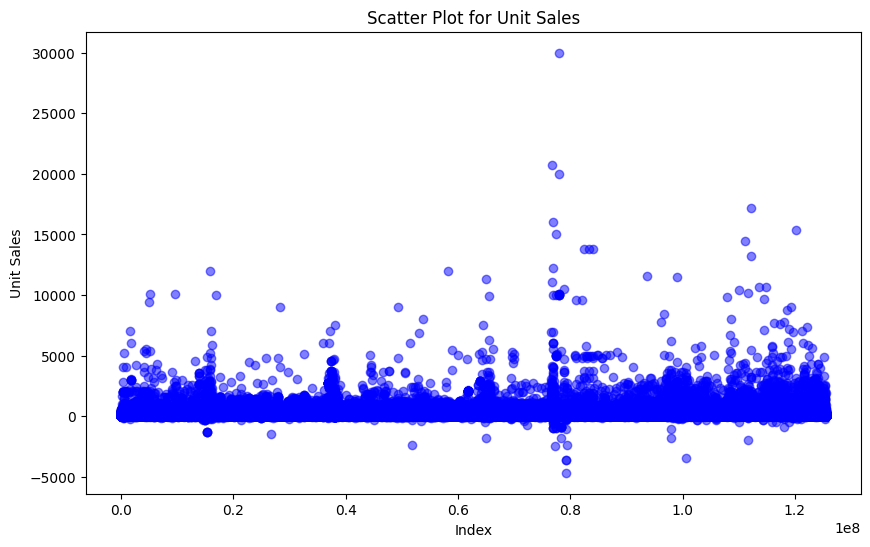

In [20]:
# Plot the scatter plot after addressing the outliers.

plt.figure(figsize=(10, 6))
plt.scatter(sales_df.index, sales_df["unit_sales"], alpha=0.5, color='blue')
plt.title("Scatter Plot for Unit Sales")
plt.xlabel("Index")
plt.ylabel("Unit Sales")
plt.show()


# Dataset 2: Items

This table contains the information of the products. It tell the category and class of an item and also whether it is perishable or not.

In [21]:
items_df = pd.read_csv("datasets/items.csv")

In [22]:
items_df.head(20)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1
5,105574,GROCERY I,1045,0
6,105575,GROCERY I,1045,0
7,105576,GROCERY I,1045,0
8,105577,GROCERY I,1045,0
9,105693,GROCERY I,1034,0


In [23]:
items_df.shape

(4100, 4)

In [24]:
# Checking if any null values exists.
null_counts = items_df[["item_nbr","family", "class", "perishable"]].isnull().sum()

print("Null values in each column:")
print(null_counts)

Null values in each column:
item_nbr      0
family        0
class         0
perishable    0
dtype: int64


Checking the data types of all columns if it is as expected.

In [25]:
print(items_df.dtypes)

item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object


The family column is categorical, lets address it.

In [26]:
# Checking the number of unique values and frequency of each value.

unique_family_value_counts = items_df["family"].value_counts()
print("The count for each value : ", unique_family_value_counts)
items_df["family"].nunique()

The count for each value :  family
GROCERY I                     1334
BEVERAGES                      613
CLEANING                       446
PRODUCE                        306
DAIRY                          242
PERSONAL CARE                  153
BREAD/BAKERY                   134
HOME CARE                      108
DELI                            91
MEATS                           84
HOME AND KITCHEN I              77
LIQUOR,WINE,BEER                73
FROZEN FOODS                    55
POULTRY                         54
HOME AND KITCHEN II             45
EGGS                            41
CELEBRATION                     31
LAWN AND GARDEN                 26
PREPARED FOODS                  26
LADIESWEAR                      21
AUTOMOTIVE                      20
LINGERIE                        20
BEAUTY                          19
PLAYERS AND ELECTRONICS         17
SCHOOL AND OFFICE SUPPLIES      15
GROCERY II                      14
PET SUPPLIES                    14
SEAFOOD             

33

Since there are 33 unique values, one hot encoding would result in large dimensions. Hence, label encoding is used to convert this categorical column

In [27]:
label_encoder = LabelEncoder()
items_df['family_encoded'] = label_encoder.fit_transform(items_df['family'])

print("DataFrame after label encoding 'family':")
print(items_df[['family', 'family_encoded']])

DataFrame after label encoding 'family':
                family  family_encoded
0            GROCERY I              12
1            GROCERY I              12
2             CLEANING               7
3            GROCERY I              12
4         BREAD/BAKERY               5
...                ...             ...
4095         GROCERY I              12
4096         GROCERY I              12
4097         GROCERY I              12
4098         BEVERAGES               3
4099  LIQUOR,WINE,BEER              22

[4100 rows x 2 columns]


In [28]:
# dropping the original family column.
items_df.drop(['family'], axis=1, inplace=True)

The 'class' column is also categorical though it is type integer. Lets check its values to see if we can do anything.

In [29]:
unique_class_value_counts = items_df["class"].value_counts()
print("The count for each value : ", unique_class_value_counts)
items_df["class"].nunique()

The count for each value :  class
1016    133
1040    110
1124    100
1034     98
1122     81
       ... 
2340      1
4139      1
1046      1
6301      1
1328      1
Name: count, Length: 337, dtype: int64


337

There are 337 unique values. We can leave it as it is or we can assign interger values from 1 to 337. I chose to use the already given values.

# Dataset 3: Stores

This table contains the information about the stores. It tell the city, state, type(small-sized, hypermarket etc.) of the store.

In [30]:
stores_df = pd.read_csv("datasets/stores.csv")

In [31]:
stores_df.head(20)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [32]:
# checking if any null values exist 
null_counts = stores_df[["store_nbr", "city", "state", "type", "cluster"]].isnull().sum()
print("Null values in each column:")
print(null_counts)

Null values in each column:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


There are no null values in this table

In [33]:
# The type column is categorical. lets analyse it first.
print("Number of unique values : ", stores_df['type'].nunique())
print("The possible values are ", stores_df['type'].unique())

Number of unique values :  5
The possible values are  ['D' 'B' 'C' 'E' 'A']


Since there are only 5 unique values, we can use one-hot encoding to represent this categorical column.

In [34]:
stores_df = pd.get_dummies(stores_df, columns=['type'])

In [35]:
# The dataframe after one-hot encoding
stores_df.head(20)

,store_nbr,city,state,cluster,type_A,type_B,type_C,type_D,type_E
0,1,Quito,Pichincha,13,False,False,False,True,False
1,2,Quito,Pichincha,13,False,False,False,True,False
2,3,Quito,Pichincha,8,False,False,False,True,False
3,4,Quito,Pichincha,9,False,False,False,True,False
4,5,Santo Domingo,Santo Domingo de los Tsachilas,4,False,False,False,True,False
5,6,Quito,Pichincha,13,False,False,False,True,False
6,7,Quito,Pichincha,8,False,False,False,True,False
7,8,Quito,Pichincha,8,False,False,False,True,False
8,9,Quito,Pichincha,6,False,True,False,False,False
9,10,Quito,Pichincha,15,False,False,True,False,False


The 'cluster' represents grouping stores into clusters with similar characteristics. Lets see if there is something that needs to  be cleaned

In [36]:
print("Number of unique values : ", stores_df['cluster'].nunique())
print("The possible values are ", stores_df['cluster'].unique())

Number of unique values :  17
The possible values are  [13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


These are already encoded and there is nothing unusual to clean/transform

# Dataset 4: Transactions

This tells us about the number of transactions that took place on a particular day at a particular store. This is not relevant data but we can just observe the data and see if we can find any trends from them. Upon checking there are no Null values in the dataset and needs no cleaning.

In [37]:
transactions_df = pd.read_csv("datasets/transactions.csv")

In [38]:
transactions_df.head(20)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [39]:
# Analysing transactions data
transactions_df['transactions'].describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

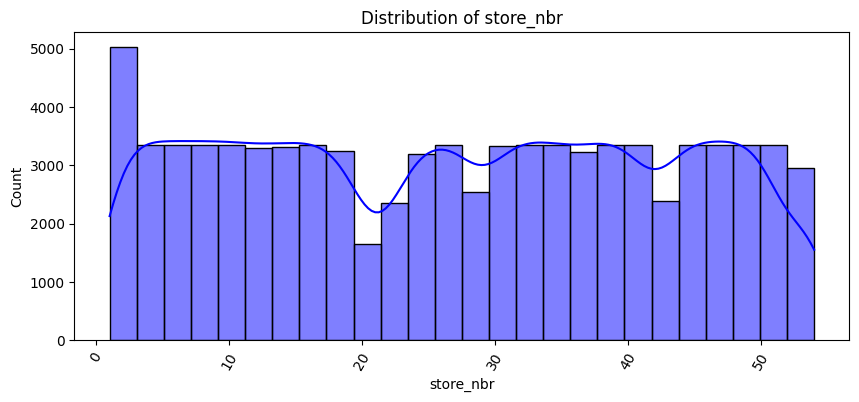

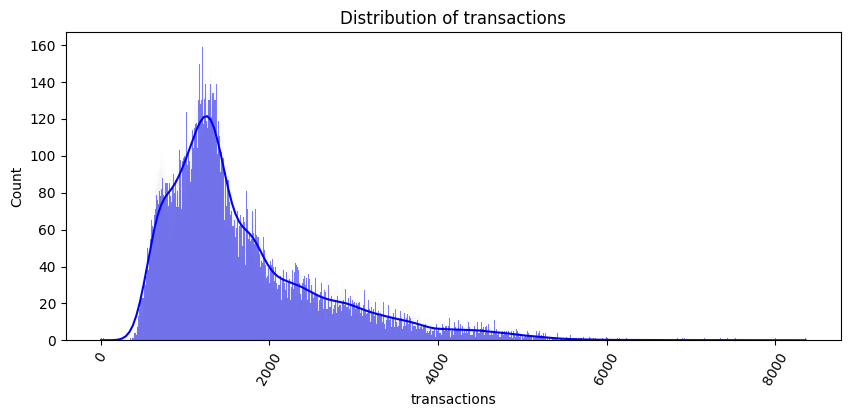

In [40]:
dataset_columns = transactions_df.describe().columns.tolist()
for i,col in enumerate(dataset_columns):
    sub_df = transactions_df[[col]]
    plt.figure(figsize = (10,4))
    plt.title(label= f'Distribution of {col}',
              loc = 'center')
    sns.histplot(data = transactions_df,
             x = f'{col}',
             binwidth =2,
             kde = True,
             color = 'blue')

    plt.xticks(rotation = 60);
    plt.show()

In [41]:
#Checking for Null values for any column in the dataset
has_na = transactions_df['date'].isna().any()
print('Null values for date column? :',has_na)
has_na = transactions_df['store_nbr'].isna().any()
print('Null values for store number column? :',has_na)
has_na = transactions_df['transactions'].isna().any()
print('Null values for transactions column? :',has_na)

Null values for date column? : False
Null values for store number column? : False
Null values for transactions column? : False


In [42]:
#Creating a copy of transactions with only date and number of transactions
temp_transactions = transactions_df[['date', 'transactions']].copy()
temp_transactions.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,2111
2,2013-01-02,2358
3,2013-01-02,3487
4,2013-01-02,1922


In [43]:
temp_transactions['date'] = pd.to_datetime(temp_transactions['date'])
grouped_transactions = temp_transactions.groupby('date', as_index=False)['transactions'].sum()
grouped_transactions.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573


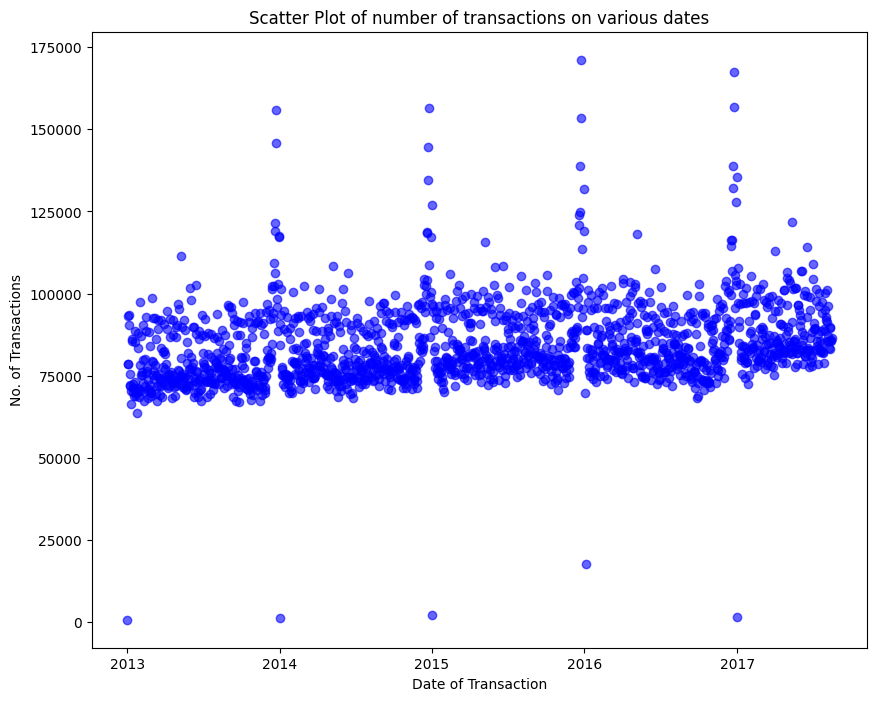

In [44]:
#Plotting the number of transactions per day over 5 years
plt.figure(figsize=(10, 8)) 
plt.scatter(grouped_transactions['date'], grouped_transactions['transactions'], color='b', alpha=0.6)
plt.xlabel('Date of Transaction')
plt.ylabel('No. of Transactions')
plt.title('Scatter Plot of number of transactions on various dates')
plt.show()

In [45]:
#Based on the graph we see that there are few transactions numbers that are way above local values
peak_transactions = grouped_transactions[grouped_transactions['transactions'] > 120000]
print(peak_transactions)

           date  transactions
354  2013-12-21        121425
356  2013-12-23        145876
357  2013-12-24        155846
719  2014-12-22        134574
720  2014-12-23        144513
721  2014-12-24        156546
727  2014-12-31        126952
1080 2015-12-19        123810
1081 2015-12-20        120843
1082 2015-12-21        124711
1083 2015-12-22        138921
1084 2015-12-23        153338
1085 2015-12-24        171169
1091 2015-12-31        131826
1445 2016-12-21        132060
1446 2016-12-22        138892
1447 2016-12-23        156932
1448 2016-12-24        167542
1453 2016-12-30        127771
1454 2016-12-31        135568
1587 2017-05-13        121889


Based on the observations we see that most of the peak number of transactions took place around the christmas eve and days before and after christmas.

In [46]:
#Based on the graph we see that there are few transactions numbers that are way below local values
minimum_transactions = grouped_transactions[grouped_transactions['transactions'] < 25000]
print(minimum_transactions)

           date  transactions
0    2013-01-01           770
364  2014-01-01          1327
728  2015-01-01          2202
1093 2016-01-04         17829
1455 2017-01-01          1642


Based on the observations we see that most of the minimum number of transactions took place around the first day of the year which is the New Year's eve where people do not spend time on shopping.

Now with all these inferences we know when the peak shopping happens and when the least shopping happens. We can utilize this dataset to populate the chances of people shopping at a store on a particular date. This can be populated based on the date and store number.

In [ ]:
#Joining the sales dataset with transactions that can populate the total number of transactions on that particular day at that store
transactions_df["date"] = pd.to_datetime(transactions_df["date"]).dt.date
train_with_shopping_chances = pd.merge(sales_df, transactions_df, on=['date', 'store_nbr'], how='inner')

In [ ]:
train_with_shopping_chances.head(20)

# Dataset 5: Oil

This tells us about the price of oil on a particular date. This can impact the chances of a person to travel and shop and also oil price usually decides the inflation and deflation in the market and helps us understand the dynamics of economics of the country on that particular day.

In [ ]:
oil_df = pd.read_csv("datasets/oil.csv")

In [ ]:
oil_df.head(20)

In [ ]:
#Checking for Null values for any column in the dataset
has_na = oil_df['date'].isna().any()
print('Null values for date column? :',has_na)
has_na = oil_df['dcoilwtico'].isna().any()
print('Null values for oil price column? :',has_na)

There are null values in the price column for oil dataset. Needs to be filled. We felt filling it with the months avaerage value would be a ideal way.

In [ ]:
#Converting date column from object to date datatype
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [ ]:
#groupingby with the month of the year and getting the average value
oil_df['year_month'] = oil_df['date'].dt.to_period('M')
monthly_avg = oil_df.groupby('year_month')['dcoilwtico'].transform('mean')
oil_df.head(10)

In [ ]:
#Filling the Null values with those average values and dropping any extra columns created in the process
oil_df['dcoilwtico'].fillna(monthly_avg, inplace=True)
oil_df.drop(columns='year_month', inplace=True)

In [ ]:
#Rounding off the price to nearest two decimal places
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].round(2)
oil_df.head(10)

In [ ]:
#Plotting the oil price trends each day over 5 years
plt.figure(figsize=(10, 8)) 
plt.scatter(oil_df['date'], oil_df['dcoilwtico'], color='b', alpha=0.6)
plt.xlabel('Dates')
plt.ylabel('Oil price(USD)')
plt.title('Graph for oil price trends over five years')
plt.show()

In [ ]:
#It felt we can create slabs for the price values and have a slab value based on the price.
oil_df['oilprice_label'] = pd.cut(oil_df['dcoilwtico'], bins=range(26, 114, 3), labels=range(1, (111 - 26) // 3 + 2))
oil_df.head()

In [ ]:
#Merging this oil price to sales data that can help decide the economics of the countryt that 
#can help estimate if people will go shopping.
#Also changing the train column datatype from object to date.
train_with_shopping_chances['date'] = pd.to_datetime(train_with_shopping_chances['date'])
train_with_oilprice_slab = pd.merge(train_with_shopping_chances, oil_df, on='date', how='inner')

In [ ]:
train_with_oilprice_slab.head(10)

# Dataset 6: Holidays

This dataset is about the holidays that is celebrated in the country. But there are a few regional and national holidays. These holidays needs to be brought down to a local city level that will help us match if a day is holiday in the sales data and will aid in predicting if the demand of the product.

In [ ]:
holidays_df = pd.read_csv("datasets/holidays_events.csv")

In [ ]:
holidays_df.head(10)

In [ ]:
#We know that the holidays is at city and date level but in the sales data we have only store number. 
#From the stores dataset we fetch the city mapped to store number and join them accordingly.
stores_df.head()

In [ ]:
#Creating a State : City_List map that helps to map regional and national holidays to cities of that state or country
grouped_store_data = stores_df.groupby('state')
state_city_map = grouped_store_data['city'].apply(list).to_dict()
for i in state_city_map:
    x = set(state_city_map[i])
    state_city_map[i] = list(x)
print(state_city_map)

In [ ]:
#Creating new dataframe with the new holidays with cities at the locale_name column
new_rows = []
for _, row in holidays_df.iterrows():
    base_row = row.to_dict()
    if base_row['locale'] == 'Regional':
        local_values = base_row['locale_name']
        for val in state_city_map[local_values]:
            new_row = base_row.copy()
            new_row['additional_value'] = val
            new_rows.append(new_row)
    
    elif base_row['locale'] == 'National':
        for i in state_city_map:
            for val in state_city_map[i]:
                new_row = base_row.copy()
                new_row['additional_value'] = val
                new_rows.append(new_row)
                
new_holidays_at_local_level = pd.DataFrame(new_rows)
new_holidays_at_local_level.head()

In [ ]:
#Cleaning the newly created dataset that can be concated later to the original holidays dataset
new_holidays_at_local_level['locale'] = 'Local'
new_holidays_at_local_level.drop('locale_name', axis=1, inplace=True)
new_holidays_at_local_level.rename(columns={'additional_value': 'locale_name'}, inplace=True)
new_holidays_at_local_level = new_holidays_at_local_level[['date', 'type', 'locale', 'locale_name', 'description', 'transferred']]
new_holidays_at_local_level.head()

In [ ]:
#Concatinating the two datasets
final_holidays = pd.concat([holidays_df, new_holidays_at_local_level], ignore_index=True)
final_holidays.head()

In [ ]:
#Changing the datatype of date column and sorting it.
final_holidays['date'] = pd.to_datetime(final_holidays['date'])
final_holidays = final_holidays.sort_values(by='date')
final_holidays.reset_index(drop=True, inplace=True)
final_holidays.rename(columns={'locale_name': 'city'}, inplace=True)
final_holidays.head()

# Data Integration and Feature Engineering

Joining all the above cleaned datasets and create some new columns to help prepare the data for in-depth analysis and predictive modelling

In [ ]:
#Joining the sales dataset with the stores dataset to get the city name for the row based on store number
train_with_city = pd.merge(train_with_oilprice_slab, stores_df, on='store_nbr', how='inner')
train_with_city.head()

In [ ]:
#Dropping unnecessary columns
train_with_city.drop(['cluster', 'state'], axis=1, inplace=True)
train_with_city.head()

In [ ]:
#Joining the sales dataset with the holidays dataset we created and populate if that particular date in that city is a holiday or not
train_with_city['holiday'] = 0
train_with_city.loc[train_with_city[['date', 'city']].merge(final_holidays, on=['date', 'city'], how='inner').index, 'holiday'] = 1

In [ ]:
train_with_city.head()

In [ ]:
train_with_city.shape

In [70]:
# Joining the information about the items as well to the above merged dataset
train_with_items = pd.merge(train_with_city, items_df, on='item_nbr', how='inner')

In [71]:
train_with_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,transactions,dcoilwtico,oilprice_label,city,type_A,type_B,type_C,type_D,type_E,holiday,class,perishable,family_encoded
0,0,2013-01-01,25,103665,7.0,0,770,94.76,23,Salinas,False,False,False,True,False,1,2712,1,5
1,19811,2013-01-02,25,103665,5.0,0,1038,93.14,23,Salinas,False,False,False,True,False,1,2712,1,5
2,100696,2013-01-04,25,103665,5.0,0,1054,93.12,23,Salinas,False,False,False,True,False,1,2712,1,5
3,224881,2013-01-07,25,103665,2.0,0,703,93.20,23,Salinas,False,False,False,True,False,1,2712,1,5
4,380595,2013-01-11,25,103665,4.0,0,979,93.60,23,Salinas,False,False,False,True,False,1,2712,1,5


In [72]:
# Day of the week can be a important factor as well to predict the sales.
# Hence the day is extracted from date and assigned a label (monday = 1, tuesday = 2 etc)
train_with_items['day_of_week'] = train_with_items['date'].dt.dayofweek + 1
print(train_with_items[['date', 'day_of_week']].head())

        date  day_of_week
0 2013-01-01            2
1 2013-01-02            3
2 2013-01-04            5
3 2013-01-07            1
4 2013-01-11            5


In [73]:
train_with_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,transactions,dcoilwtico,oilprice_label,city,type_A,type_B,type_C,type_D,type_E,holiday,class,perishable,family_encoded,day_of_week
0,0,2013-01-01,25,103665,7.0,0,770,94.76,23,Salinas,False,False,False,True,False,1,2712,1,5,2
1,19811,2013-01-02,25,103665,5.0,0,1038,93.14,23,Salinas,False,False,False,True,False,1,2712,1,5,3
2,100696,2013-01-04,25,103665,5.0,0,1054,93.12,23,Salinas,False,False,False,True,False,1,2712,1,5,5
3,224881,2013-01-07,25,103665,2.0,0,703,93.20,23,Salinas,False,False,False,True,False,1,2712,1,5,1
4,380595,2013-01-11,25,103665,4.0,0,979,93.60,23,Salinas,False,False,False,True,False,1,2712,1,5,5


The previous seven day average sales of a particular item at a particular store will be an important factor to predict the future sales. The window may be adjust to best suit the model in phase 3.

In [74]:
# Creating a new column that stores the average sales for the previous 7 days window.
train_with_items = train_with_items.sort_values(by=['store_nbr', 'item_nbr', 'date'])
train_with_items['weekly_avg_sales'] = train_with_items.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean().round(3))
print(train_with_items[['date', 'store_nbr', 'item_nbr', 'unit_sales', 'weekly_avg_sales']].head(10))

               date  store_nbr  item_nbr  unit_sales  weekly_avg_sales
43293980 2013-01-10          1     96995         1.0             1.000
43293981 2013-01-11          1     96995         1.0             1.000
43293982 2013-01-14          1     96995         1.0             1.000
43293983 2013-01-18          1     96995         2.0             1.250
43293984 2013-01-21          1     96995         1.0             1.200
43293985 2013-01-25          1     96995         1.0             1.167
43293986 2013-01-28          1     96995         1.0             1.143
43293987 2013-01-31          1     96995         1.0             1.143
43293988 2013-02-05          1     96995         1.0             1.143
43293989 2013-02-13          1     96995         4.0             1.571


In [75]:
print("The final data frame after cleaning, data integration and feature engineering")
train_with_items.head(20)

The final data frame after cleaning, data integration and feature engineering


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,transactions,dcoilwtico,oilprice_label,city,...,type_B,type_C,type_D,type_E,holiday,class,perishable,family_encoded,day_of_week,weekly_avg_sales
43293980,324276,2013-01-10,1,96995,1.0,0,1679,93.81,23,Quito,...,False,False,True,False,1,1093,0,12,4,1.000
43293981,362634,2013-01-11,1,96995,1.0,0,1813,93.60,23,Quito,...,False,False,True,False,1,1093,0,12,5,1.000
43293982,486204,2013-01-14,1,96995,1.0,0,1780,94.27,23,Quito,...,False,False,True,False,1,1093,0,12,1,1.000
43293983,644444,2013-01-18,1,96995,2.0,0,1745,95.61,24,Quito,...,False,False,True,False,1,1093,0,12,5,1.250
43293984,770056,2013-01-21,1,96995,1.0,0,1770,94.76,23,Quito,...,False,False,True,False,1,1093,0,12,1,1.200
43293985,927560,2013-01-25,1,96995,1.0,0,1770,95.15,24,Quito,...,False,False,True,False,1,1093,0,12,5,1.167
43293986,1052871,2013-01-28,1,96995,1.0,0,1738,95.95,24,Quito,...,False,False,True,False,1,1093,0,12,1,1.143
43293987,1171957,2013-01-31,1,96995,1.0,0,1707,97.65,24,Quito,...,False,False,True,False,1,1093,0,12,4,1.143
43293988,1384585,2013-02-05,1,96995,1.0,0,1775,96.68,24,Quito,...,False,False,True,False,1,1093,0,12,2,1.143
43293989,1710821,2013-02-13,1,96995,4.0,0,1921,97.03,24,Quito,...,False,False,True,False,1,1093,0,12,3,1.571
